# ENV / ATM 415: Climate Laboratory

# Introducing the Community Earth System Model

_____________________________________

## About the model

We are using a version of the Community Earth System Model (CESM) which is developed and maintained at the National Center for Atmospheric Research in Boulder, CO. See the CESM website here: http://www2.cesm.ucar.edu

Our experiments will use CESM in the so-called "Slab Ocean Model" mode, in which the ocean is represented by a static layer of water with some heat capacity but no motion. This greatly simplifies the necessary calculations, particularly the time required for the model to reach equilibrium. The net effect heat transport by ocean currents is prescribed through a so-called "q-flux", which really just means we prescribed sources and sinks of heat at different locations. For (lots of) details, see http://www2.cesm.ucar.edu/working-groups/pwg/documentation/cesm1-paleo-toolkit/ocean/som


### Atmosphere
 - Horizontal resolution about 2º lat/lon
 - AGCM solves the fundamental equations:
    - Conservation of momentum, mass, energy, water, equation of state
 - Model also solves equations of **radiative transfer**. This takes account of
     - composition of the atmosphere
     - absorption properties of different gases
     - radiative effects of **clouds**.
 - At 2º we resolve the **synoptic-scale dynamics**
     - storm tracks and cyclones. 
 - We do NOT resolve the mesoscale and smaller
     - thunderstorms, individual convective events, clouds
 - These all must be parameterized.


### Sea ice
- Resolution of 1º.
- Thermodynamics (conservation of energy, water and salt)
    - determines freezing and melting
- Dynamics (momentum equations) 
    - determine ice motion and deformation.
- Complex! Sea ice is sort of a mixture of a fluid and a solid.

### Land surface model
- Same resolution as atmosphere. 
- Determines surface fluxes of heat, water, momentum (friction) based on prescribed vegetation types.

### Ocean
- Same grid as sea ice, 1º.
- Sea surface temperature evolves based on:
    - heat exchange with atmosphere
    - prescribed “q-flux”.

### Experimental setup

Model is given realistic atmospheric composition, realistic solar radiation, etc.

We perform a **control run** to get a baseline simulation, and take **averages of several years** (because the model has internal variability – every year is a little bit different)

We then change something, e.g. $2\times CO_2$!

And allow the model to adjust to a new equilibrium, just as we've done with our various simple models.

Once it has gotten close to its new equilibrium, we run it for several more years again to get the new climatology.

Then we can look at the **differences in the climatologies before and after the perturbation**.

The model runs on one of our local compute clusters here at U. Albany. We can simulate about 5 years per day by running the model on 32 cores. Equilibration time for the slab ocean model is roughly 20 years. Thus it takes a few days to run any particularly scenario out to equilibrium. The atmospheric GCM uses about half of the cpu time, the sea ice uses about one quarter, and the rest goes to the land model, the coupler, and various other bits and pieces.

We will begin with a "control run", i.e. we will set up the model with (approximately) realistic conditions and run it out to equilibrium. We can then measure how well our simulated climate agrees with observations.

_______________________________

## What can we resolve with a 2º atmosphere?
____________

The following animation shows contours of sea level pressure in the control simulation. It is based on 6-hourly output from the numerical model.

The atmosphere is simulated with a 2º finite volume dynamical core.

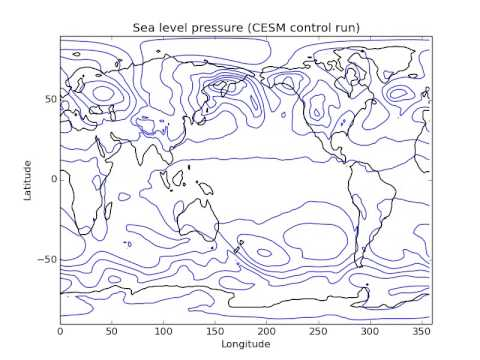

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('As85L34fKYQ')

### Discussion point:
How well does this represent the true general circulation of the atmosphere?

____________________________________
## Description of input

First, let's take a look at some of the ingredients that go into the control run. **All of the necessary data will be served up by a special data server sitting in the department**, so you should be able to run this code to interact with the data on any computer that is connected to the internet.

### You need to be connected to the internet to run the code in this notebook ###

You can browse the available data through a web interface here:

<http://ramadda.atmos.albany.edu:8080/repository/entry/show/Top/Users/Brian+Rose/CESM+runs>

Within this folder called `CESM runs`, you will find another folder called `som_input` which contains all the input files.

The data are all stored in `NetCDF` files. Python has some nice interfaces for working with `NetCDF` data files, including accessing files remotely over the internet. To begin, we need to import the Python package `netCDF4` to read the data files.

We also set the notebook to `inline` graphics mode to display figures right here in the notebook.

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc

You are encouraged to experiment and tinker with all the code below.

### Boundary conditions: continents and topography

Here we are going to load the input topography file and take a look at what's inside. 

We use the `Dataset` object from the `netCDF4` module as our basic container for any `netCDF` data. `Dataset()` requires at least one argument telling it what file to open. This can either be a file on your local disk or a URL.

In this case we are passing it a URL to our online dataserver. We'll put the URL in a string variable called `datapath` to simplify things later on.

In [3]:
datapath = "http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/"
endstr = "/entry.das"

#  Notice that in Python we can easily concatenate strings together just by `adding` them
fullURL = datapath + 'som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc' + endstr
print fullURL

http://ramadda.atmos.albany.edu:8080/repository/opendap/latest/Top/Users/Brian+Rose/CESM+runs/som_input/USGS-gtopo30_1.9x2.5_remap_c050602.nc/entry.das


In [4]:
#  Now we actually open the file
topo = nc.Dataset( fullURL )
print topo

<type 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format UNDEFINED):
    history: Written on date: 20050602
definesurf -remap -t /fs/cgd/csm/inputdata/atm/cam/topo/USGS-gtopo30_10min_c050419.nc -g /fs/cgd/csm/inputdata/atm/cam/coords/fv_1.9x2.5.nc -l /fs/cgd/csm/inputdata/atm/cam2/hrtopo/landm_coslat.nc USGS-gtopo30_1.9x2.5_remap_c05060
    make_ross: true
    topofile: /fs/cgd/csm/inputdata/atm/cam/topo/USGS-gtopo30_10min_c050419.nc
    gridfile: /fs/cgd/csm/inputdata/atm/cam/coords/fv_1.9x2.5.nc
    landmask: /fs/cgd/csm/inputdata/atm/cam2/hrtopo/landm_coslat.nc
    dimensions(sizes): lat(96), lon(144)
    variables(dimensions): float64 lat(lat), float64 lon(lon), float64 PHIS(lat,lon), float64 SGH(lat,lon), float64 SGH30(lat,lon), float64 LANDFRAC(lat,lon), float64 LANDM_COSLAT(lat,lon)
    groups: 



The `Dataset` object has several important attributes. Much of this should look familiar if you have worked with `netCDF` data before. This Python interface to `netCDF` stores most of the data in dictionaries. For example, the actual variables contained in this dataset are:

In [5]:
for v in topo.variables: print(v)

lat
lon
PHIS
SGH
SGH30
LANDFRAC
LANDM_COSLAT


The output of our little for loop is a list of variable names contained in the file we just opened -- actually the keys to the dictionary called `variables`. Each variables contains some data along with a bunch of descriptive information about the data. Here's an example:

In [6]:
print topo.variables['PHIS']

<type 'netCDF4._netCDF4.Variable'>
float64 PHIS(lat, lon)
    _FillValue: 1e+36
    missing_value: 1e+36
    long_name: surface geopotential
    units: m2/s2
    from_hires: true
    filter: remap
unlimited dimensions: 
current shape = (96, 144)
filling off



### Getting the actual data

This shows the syntax for reading a particular variable, which in this code is the surface geopotential (from which we can get surface elevation). It will be handy to store the grid information (latitude and longitude) in some local arrays. **The example below shows that by adding `[:]` at the end of the expression, we reference just the data itself (which is stored as a `numpy` array) and not the accompanying decription.** In the Python world this is called *slicing*. You can get subsets of the data by taking a smaller slice, using array indexing.

In [7]:
lat = topo.variables['lat'][:]
lon = topo.variables['lon'][:]
print lat.shape, lon.shape

(96,) (144,)


Now we have made local copies of these two arrays that contain coordinate information for the actual data in the file. The `.shape` command used above (which works for any `numpy` array) gives us information about the dimensions of the arrays, in this case, 96 latitude points and 144 longitude points. If you like can also try just typing 

`print lat` 

or 

`print lon` 

and see the coordinates themselves.

### Plotting the topography

We will now read the geopotential and make a plot of the topography of the Earth's surface as represented on the 2º grid. The code below makes a colorful plot of the topography. We also use the land-sea mask in order to plot nothing at grid points that are entirely ocean-covered. 

Execute this code exactly as written first, and then play around with it to see how you might customize the graph. 

Note that the function `pcolormesh` does most of the work here. It's a function that makes color 2D plots of an array.

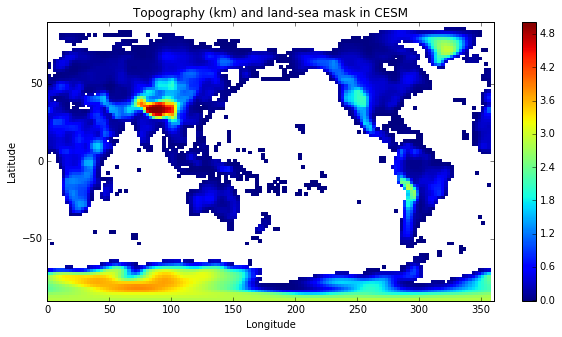

In [8]:
height = topo.variables['PHIS'][:] / 9.8 / 1000  # in kilometers

#  This makes use of the `masked array`, part of the numpy module
#  essentially a numpy array with a mask of the same size
height_masked = np.ma.MaskedArray(height, topo.variables['LANDFRAC'][:] == 0. )

fig1 = plt.figure(figsize=(10,5))
ax1 = fig1.add_subplot(1, 1, 1)
cax1 = ax1.pcolormesh( lon, lat, height_masked )
ax1.set_title('Topography (km) and land-sea mask in CESM')
ax1.axis([0, 360, -90, 90])
ax1.set_xlabel('Longitude'); ax1.set_ylabel('Latitude');
cbar1 = plt.colorbar(cax1);

Note that at 2º resolution we can see many smaller features (e.g. Pacific islands). The model is given a fractional land cover for each grid point. 

Here let's plot the land-sea mask itself so we can see where there is at least "some" water:

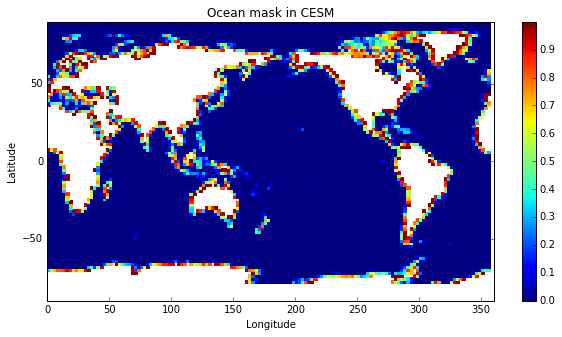

In [9]:
ocean_mask = np.ma.MaskedArray( topo.variables['LANDFRAC'][:], topo.variables['LANDFRAC'][:] == 1. )

fig2 = plt.figure(figsize=(10,5))
ax2 = fig2.add_subplot(1, 1, 1)
cax2 = ax2.pcolormesh( lon, lat, ocean_mask )
ax2.set_title('Ocean mask in CESM')
ax2.axis([0, 360, -90, 90])
ax2.set_xlabel('Longitude'); ax2.set_ylabel('Latitude')
cbar2 = plt.colorbar(cax2);

### Making nicer maps

Notice that to make these plots we've just plotted the lat-lon array without using any map projection.

There are nice tools available to make better maps. If you're keen to learn about this, check out:

<http://matplotlib.org/basemap/>

and

<http://scitools.org.uk/cartopy/>

## Ocean boundary conditions

Another important input file contains information about the slab ocean. You can see this file in the data catalog here:

<http://ramadda.atmos.albany.edu:8080/repository/entry/show/Top/Users/Brian+Rose/CESM+runs/som_input/pop_frc.1x1d.090130.nc>

Let's load it and take a look.

In [10]:
som_input = nc.Dataset( datapath + 'som_input/pop_frc.1x1d.090130.nc' + endstr )
for v in som_input.variables: print v

area
mask
yc
xc
time
S
T
U
V
dhdx
dhdy
hblt
qdp


The ocean / sea ice models exist on different grids than the atmosphere (1º instead of 2º resolution). Let's store the new coordinate information just like we did for the atmosphere grid.

In [11]:
lon_som = som_input.variables['xc'][:]
lat_som = som_input.variables['yc'][:]
print lon_som.shape, lat_som.shape

(360,) (180,)


Now we are going to look at the **annual mean heat flux out of the ocean**, which is the prescribed 'q-flux' that we give to the slab ocean model.

It is stored in the field `qdp` in the input file. 

The sign convention in CESM is that `qdp > 0` where **heat is going IN to the ocean**. We will change the sign to plot heat going OUT of the ocean INTO the atmosphere (a more atmosphere-centric viewpoint). 

First, let's just look at the size of the data array:

In [12]:
np.shape(som_input.variables['qdp'][:])

(12, 180, 360)

This means that there are 12 x 180 x 360 data points. One 180 x 360 grid for each calendar month!

Now we are going to take the average over the year at each point. We will use a very convenient array function np.mean(), which just computes the mean point-by-point. This leaves us with a single grid on 180 latitude points by 360 longitude points:

In [13]:
qdp_an = np.mean( som_input.variables['qdp'][:], axis=0 )
#  Note that we have to tell numpy which axis to average over
#  By default it will average over all axes simultaneously 
print qdp_an.shape

(180, 360)


Now make a nice plot of the annual mean q-flux. This code also overlays a contour of the land-sea mask for reference. 

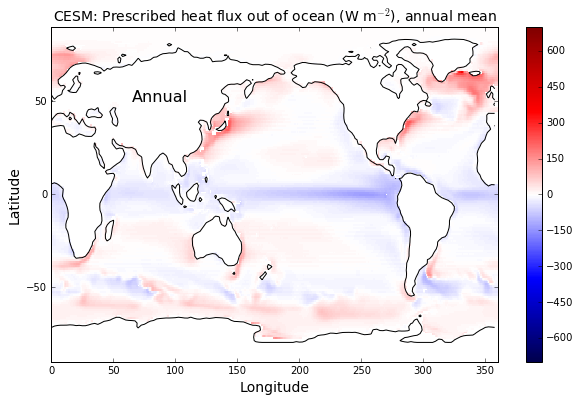

In [14]:
#  We can always set a non-standard size for our figure window
fig3 = plt.figure(figsize=(10, 6))
ax3 = fig3.add_subplot(111)
cax3 = ax3.pcolormesh( lon_som, lat_som, -qdp_an, cmap=plt.cm.seismic, vmin=-700., vmax=700. )
cbar3 = plt.colorbar(cax3)
ax3.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$), annual mean', fontsize=14 )
ax3.axis([0, 360, -90, 90], fontsize=12)
ax3.set_xlabel('Longitude', fontsize=14)
ax3.set_ylabel('Latitude', fontsize=14)
ax3.contour( lon, lat, topo.variables['LANDFRAC'][:], [0.5], colors='k');
ax3.text(65, 50, 'Annual', fontsize=16 );

Notice all the spatial structure here: 

- Lots of heat is going in to the oceans at the equator, particularly in the eastern Pacific Ocean.
- The red hot spots show where lots of heat is coming out of the ocean.
- Hot spots include the mid-latitudes off the eastern coasts of Asia and North America
- And also the northern North Atlantic. 

**All this structure is determined by ocean circulation, which we are not modeling here.** Instead, we are prescribing these heat flux patterns as an input to the atmosphere.

This pattern changes throughout the year. Recall that we just averaged over all months to make this plot. We might want to look at just one month:

In [15]:
qdp_jan = som_input.variables['qdp'][0,:,:]
qdp_jan.shape

(180, 360)

Here we got just the first month (January) by specifying `[0,:,:]` after the variable name. This is called slicing or indexing an array. We are saying "give me everything for month number 1". Now make the plot:

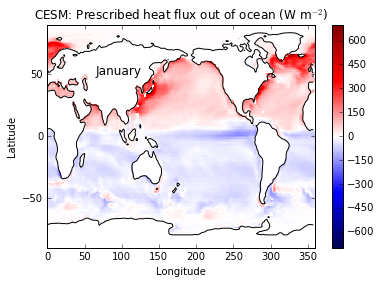

In [16]:
fig4 = plt.figure(); 
ax4 = fig4.add_subplot(111)
cax4 = ax4.pcolormesh( lon_som, lat_som, -qdp_jan, cmap=plt.cm.seismic, vmin=-700., vmax=700. )
cbar4 = plt.colorbar(cax3)
ax4.set_title( 'CESM: Prescribed heat flux out of ocean (W m$^{-2}$)' )
ax4.axis([0, 360, -90, 90])
ax4.set_xlabel('Longitude')
ax4.set_ylabel('Latitude')
ax4.contour( lon, lat, topo.variables['LANDFRAC'][:], [0.5], colors='k');
ax4.text(65, 50, 'January', fontsize=12 );

### Just for fun: some interactive plotting

`IPython` provides some really neat and easy-to-use tools to set up interactive graphics in your notebook.

Here we're going to create a figure with a slider that lets of step through each month of the q-flux data.

In [17]:
#  The variable we want to plot
qdp = som_input.variables['qdp'][:]
#  A function that makes a plot for a given month (which we pass as an argument)
#   note... imshow is an alternate way to generate an image from a data array
#  Faster than pcolormesh (which is why I use it here)
#   but not as flexible
def sh(month):
    plt.imshow(np.flipud(-qdp[month,:,:]), cmap=plt.cm.seismic, vmin=-700., vmax=700. )
    plt.colorbar()

When you execute the next cell, you should get a figure with a slider above it. Go ahead and play with it.

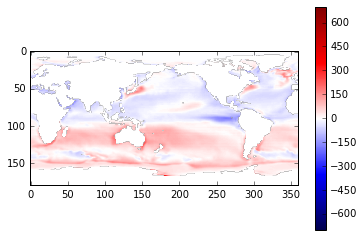

In [18]:
from ipywidgets import interact
interact(sh, month=(0,11,1));

## The "pre-industrial" control run

Our control run is set up to simulate the climate of the "pre-industrial era", meaning before significant human-induced changes to the composition of the atmosphere, nominally the year 1850.

Output from the control run is available on the same data server as above. Look in the folder called `som_1850_f19` (Here `som` stands for "slab ocean model", 1850 indicated pre-industrial conditions, and `f19` is a code for the horizontal grid resolution).

There are climatology files for each active model component:

- atmosphere, 
- sea ice
- land surface 

I created these files by **averaging over the last 10 years of the simulation**. Let's take a look at the atmosphere file. The file is called

`som_1850_f19.cam.h0.clim.nc`

(the file extension `.nc` is used to indicate NetCDF format).

Output from the control run is available on the same data server as above. Look in the folder called som_control.

There are climatology files for the atmosphere, sea ice, and land surface. I created these files by averaging over the last 10 years of the simulation. Let's take a look at the atmosphere file. You can look up the necessary URL by following the procedure outlined above. The file is called

som_control.cam.h0.clim.nc

(the file extension .nc is used to indicate NetCDF format).

Or just copy the following:

In [19]:
atm_control = nc.Dataset( datapath + 'som_1850_f19/som_1850_f19.cam.h0.clim.nc' + endstr )

Now we would like to see what's in this file, same as before:

In [20]:
for v in atm_control.variables: print v

lev
hyam
hybm
ilev
hyai
hybi
P0
time
date
datesec
lat
lon
slat
slon
w_stag
time_bnds
date_written
time_written
ntrm
ntrn
ntrk
ndbase
nsbase
nbdate
nbsec
mdt
nlon
wnummax
gw
ndcur
nscur
co2vmr
ch4vmr
n2ovmr
f11vmr
f12vmr
sol_tsi
nsteph
AEROD_v
CLDHGH
CLDICE
CLDLIQ
CLDLOW
CLDMED
CLDTOT
CLOUD
CONCLD
DCQ
DTCOND
DTV
EMIS
FICE
FLDS
FLDSC
FLNS
FLNSC
FLNT
FLNTC
FLUT
FLUTC
FSDS
FSDSC
FSDTOA
FSNS
FSNSC
FSNT
FSNTC
FSNTOA
FSNTOAC
FSUTOA
ICEFRAC
ICIMR
ICWMR
LANDFRAC
LHFLX
LWCF
MSKtem
OCNFRAC
OMEGA
OMEGAT
PBLH
PHIS
PRECC
PRECL
PRECSC
PRECSL
PS
PSL
Q
QFLX
QREFHT
QRL
QRS
RELHUM
SFCLDICE
SFCLDLIQ
SHFLX
SNOWHICE
SNOWHLND
SOLIN
SWCF
T
TAUX
TAUY
TGCLDCWP
TGCLDIWP
TGCLDLWP
TH
TH2d
TMQ
TREFHT
TS
TSMN
TSMX
U
U10
U2d
UTGWORO
UU
UV2d
UV3d
UW2d
UW3d
V
V2d
VD01
VQ
VT
VTH2d
VTH3d
VU
VV
W2d
WTH3d
Z3


Lots of different stuff! These are all the different quantities that are calculated as part of the model simulation. **Every quantity represents a long-term average for a particular month**. 

Want to get more information about a particular variable?

In [21]:
print atm_control.variables['SOLIN']

<type 'netCDF4._netCDF4.Variable'>
float32 SOLIN(time, lat, lon)
    Sampling_Sequence: rad_lwsw
    units: W/m2
    long_name: Solar insolation
    cell_methods: time: mean time: mean
unlimited dimensions: time
current shape = (12, 96, 144)
filling off



Apparently this is the incoming solar radiation or **insolation**, with shape (12,96,144) meaning it's got 12 months, 96 latitude points and 144 longitude points. 

### Your task, for now....

Is just to play with the data in this file. Try to figure out what some of the different fields are. Get familiar with the data and with making plots.

Some fields you might want to look at:

- surface temperature, 'TS'

- Outgoing longwave radiation, 'FLNT'

- Net absorbed shortwave, 'FSNT'

These are all 12 x 96 x 144 -- i.e. a two-dimensional grid for every calendar month.

Many other fields are three-dimensional. For example, here is the shape of the array that hold the air temperature at every point and every month:

In [22]:
np.shape( atm_control.variables['T'] )

(12, 26, 96, 144)

And here is some code to plot the average sounding (temperature as function of pressure) at a particular point in the month of January.

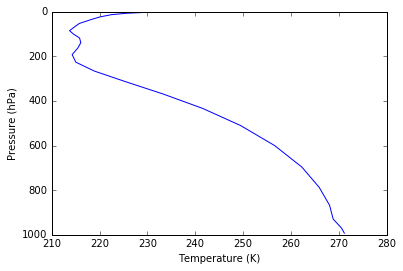

In [23]:
plt.plot( atm_control.variables['T'][1,:,70,115], atm_control.variables['lev'] )
plt.gca().invert_yaxis()
plt.ylabel('Pressure (hPa)')
plt.xlabel('Temperature (K)')

What was the location we just used for that plot? Let's check by indexing the latitude and longitude arrays we previously stored:

In [24]:
lat[70], lon[115]

(42.631578947368418, 287.5)

These are actually the coordinates of the Albany area (read longitude in degrees east).

### So go ahead and mess around with the model output and see what you can do with it. And have fun.

Thanks for playing!